# physionet2012 데이터 전처리
- 데이터 가져오기
- scaler 가져오기
- X, y 분리하기
- scaler 적용하기
- model에 입력가능한 3차원 형태 데이터 만들기
- (batch_size, maxlen, feature_dim)

In [1]:
# 전처리된 데이터 가져오기

import numpy as np
import pandas as pd

path = '/Users/jsha/gjai/final_project/black_swan_physionet/'
file = 'train_done_preprocessing.csv'
file2 = 'valid_done_preprocessing.csv'
file3 = 'test_done_preprocessing.csv'

train_df = pd.read_csv(path+file)
valid_df = pd.read_csv(path+file2)
test_df = pd.read_csv(path+file3)

maxlen = len(train_df[train_df['pid'] == train_df['pid'][0]])

In [2]:
len(train_df.columns)

46

In [3]:
# labels 컬럼 인덱스 찾기
inx = test_df.columns.get_indexer(['labels'])
print(inx)

# X, y 분리
y_train = train_df['labels']
X_train_nonorm = train_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_train.shape)
print(X_train_nonorm.shape)

y_valid = valid_df['labels']
X_valid_nonorm = valid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_valid.shape)
print(X_valid_nonorm.shape)

y_test = test_df['labels']
X_test_nonorm = test_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_test.shape)
print(X_test_nonorm.shape)

[41]
(226800,)
(226800, 40)
(25200,)
(25200, 40)
(28000,)
(28000, 40)


In [4]:
# scaler를 이용한 정규화

import pickle

mms = 'mms.pickle'
with open(path+mms, 'rb') as handler:
    load_mms = pickle.load(handler)
    
X_train = load_mms.transform(X_train_nonorm)
X_valid = load_mms.transform(X_valid_nonorm)
X_test = load_mms.transform(X_test_nonorm)

print(X_train.shape)
print(y_train.shape)
X_train_3d = X_train.reshape((-1, maxlen, X_train.shape[-1]))
print(X_train_3d.shape)
y_train_3d = y_train[::maxlen]
print(y_train_3d.shape)

X_valid_3d = X_valid.reshape((-1, maxlen, X_valid.shape[-1]))
print(X_valid_3d.shape)
y_valid_3d = y_valid[::maxlen]
print(y_valid_3d.shape)

X_test_3d = X_test.reshape((-1, maxlen, X_test.shape[-1]))
print(X_test_3d.shape)
y_test_3d = y_test[::maxlen]
print(y_test_3d.shape)

(226800, 40)
(226800,)
(3240, 70, 40)
(3240,)
(360, 70, 40)
(360,)
(400, 70, 40)
(400,)


# Model 설계 

## bidirectional_model

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Bidirectional, Input

max_len = len(X_train_3d[0])
feature_dim = X_train_3d.shape[-1]

inp = Input(shape=(max_len, feature_dim))
hidden = LSTM(64, activation='tanh', return_sequences=True)(inp)
hidden = Bidirectional(LSTM(64, activation='tanh'))(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Dense(32, activation='relu')(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Dense(8, activation='relu')(hidden)
outp = Dense(1, activation='sigmoid')(hidden)

bidirec_model = Model(inputs=[inp], outputs=[outp])

2022-11-30 14:46:39.364744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
bidirec_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 40)]          0         
                                                                 
 lstm (LSTM)                 (None, 70, 64)            26880     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                             

In [7]:
bidirec_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'AUC'])

In [8]:
# 모델 학습하기

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 20
batch_size = 40
model_name = 'chp_bidirec_model.h5'

early_stopping = EarlyStopping(monitor='val_auc', patience=4, verbose=1)
checkpoint = ModelCheckpoint(path+model_name, monitor='val_auc', save_best_only=True)

history = bidirec_model.fit(X_train_3d, y_train_3d, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_valid_3d, y_valid_3d), callbacks=[early_stopping, checkpoint])


Epoch 1/20
81/81 [==============================] - 8s 61ms/step - loss: 0.4640 - acc: 0.8410 - auc: 0.5001 - val_loss: 0.3978 - val_acc: 0.8639 - val_auc: 0.5985
Epoch 2/20
81/81 [==============================] - 4s 48ms/step - loss: 0.4166 - acc: 0.8673 - auc: 0.5002 - val_loss: 0.3962 - val_acc: 0.8639 - val_auc: 0.6740
Epoch 3/20
81/81 [==============================] - 4s 50ms/step - loss: 0.4001 - acc: 0.8679 - auc: 0.5578 - val_loss: 0.3628 - val_acc: 0.8639 - val_auc: 0.7932
Epoch 4/20
81/81 [==============================] - 4s 49ms/step - loss: 0.3969 - acc: 0.8682 - auc: 0.5809 - val_loss: 0.3593 - val_acc: 0.8639 - val_auc: 0.7602
Epoch 5/20
81/81 [==============================] - 4s 48ms/step - loss: 0.3760 - acc: 0.8673 - auc: 0.6642 - val_loss: 0.3315 - val_acc: 0.8639 - val_auc: 0.8004
Epoch 6/20
81/81 [==============================] - 4s 54ms/step - loss: 0.3556 - acc: 0.8682 - auc: 0.7287 - val_loss: 0.3356 - val_acc: 0.8639 - val_auc: 0.7985
Epoch 7/20
81/81 [====

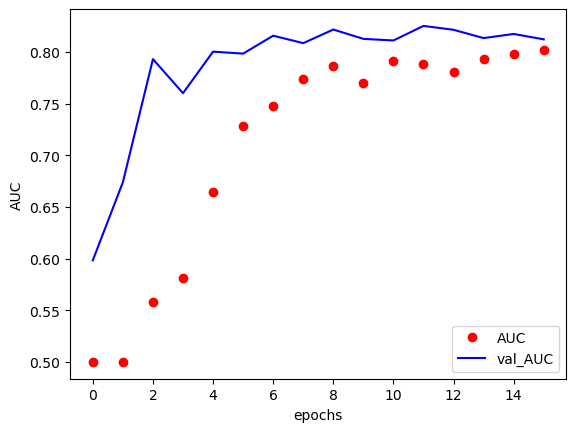

In [9]:
# epoch별 model acc 비교하기 

import matplotlib.pyplot as plt

history = history.history
history
loss = history['loss']
acc = history['acc']
auc = history['auc']
val_loss = history['val_loss']
val_acc = history['val_acc']
val_auc = history['val_auc']
length = len(val_loss)

plt.plot(range(length), auc, 'ro', label='AUC')
plt.plot(range(length), val_auc, 'b-', label='val_AUC')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend()

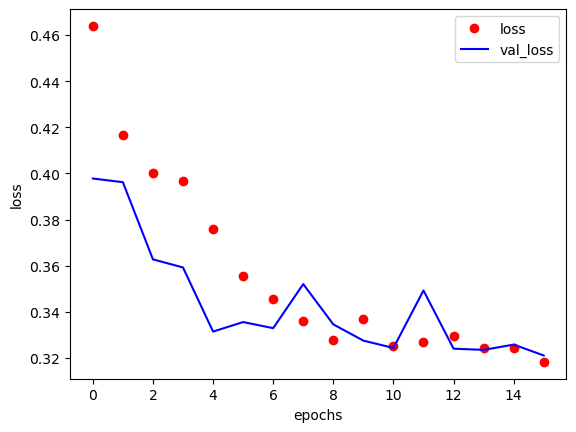

In [10]:
# epoch별 모델 loss 확인하기

plt.plot(range(length), loss, 'ro', label='loss')
plt.plot(range(length), val_loss, 'b-', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [11]:
# test loss, acc, auc 구하기1
test_loss, test_acc, test_auc = bidirec_model.evaluate(X_test_3d, y_test_3d)
print(f'test_acc: {test_acc:.4f}')
print(f'test_auc: {test_auc:.4f}')


# auroc 구하기2
from sklearn.metrics import roc_auc_score

test_pred = bidirec_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 1s 13ms/step - loss: 0.3065 - acc: 0.8750 - auc: 0.8210
test_acc: 0.8750
test_auc: 0.8210
13/13 [==============================] - 1s 13ms/step
acc_test: 0.8750
auc_score_test: 0.8205


In [12]:
bidirec_model.save(path+'bidirec_model_best_upto.h5')

In [13]:
from keras.models import load_model
from sklearn.metrics import roc_auc_score

loaded_model = load_model(path+'bidirec_model_best_upto.h5')

test_loss, test_acc, test_auc = loaded_model.evaluate(X_test_3d, y_test_3d)
test_pred = loaded_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 1s 13ms/step
acc_test: 0.8750
auc_score_test: 0.8205
